##### Copyright 2019 The TensorFlow Authors.

In [74]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from PIL import Image
import os
import numpy
from numpy import asarray

cwd = os.getcwd()

# Define the preprocessing function
def preprocess_image(img_path):
    """Resize the image to (32, 32) and keep RGB channels."""
    img = Image.open(img_path).resize((32, 32))
    if img.mode != 'RGB':
        img = img.convert('RGB')  # Ensure image is in RGB mode
    return np.array(img)

# Preprocess training data
train_img_folder = '/visual_results_train(2560)'
train_img_direc = cwd + train_img_folder
train_array_list = [preprocess_image(os.path.join(train_img_direc, img)) for img in os.listdir(train_img_direc)]
train_img_array = np.stack(train_array_list)
print(train_img_array.shape)

# Preprocess test data
test_img_folder = '/visual_results_test(640)'  # Adjust if your test folder has a different name
test_img_direc = cwd + test_img_folder
test_array_list = [preprocess_image(os.path.join(test_img_direc, img)) for img in os.listdir(test_img_direc)]
test_img_array = np.stack(test_array_list)
print(test_img_array.shape)



(2561, 32, 32, 3)
(656, 32, 32, 3)


In [75]:
train_ans_array = numpy.random.randint(0, 4 + 1, size=(train_img_array.shape[0], 1))
test_ans_array = numpy.random.randint(0, 4 + 1, size=(test_img_array.shape[0], 1))
print(train_ans_array.shape) 
print(test_ans_array.shape) 

(2561, 1)
(656, 1)


# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [76]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [77]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
print("Type: ", type(train_images))
print("Type: ", type(train_labels))
print(train_images.shape)
print(train_labels.shape)
print("Type: ", type(test_images))
print("Type: ", type(test_labels))
print(test_images.shape)
print(test_labels.shape)
print(test_labels)
print("++++")
print(test_labels[0])
print(train_img_array.shape)
print(test_img_array.shape)

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


Type:  <class 'numpy.ndarray'>
Type:  <class 'numpy.ndarray'>
(50000, 32, 32, 3)
(50000, 1)
Type:  <class 'numpy.ndarray'>
Type:  <class 'numpy.ndarray'>
(10000, 32, 32, 3)
(10000, 1)
[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]
++++
[3]
(2561, 32, 32, 3)
(656, 32, 32, 3)


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


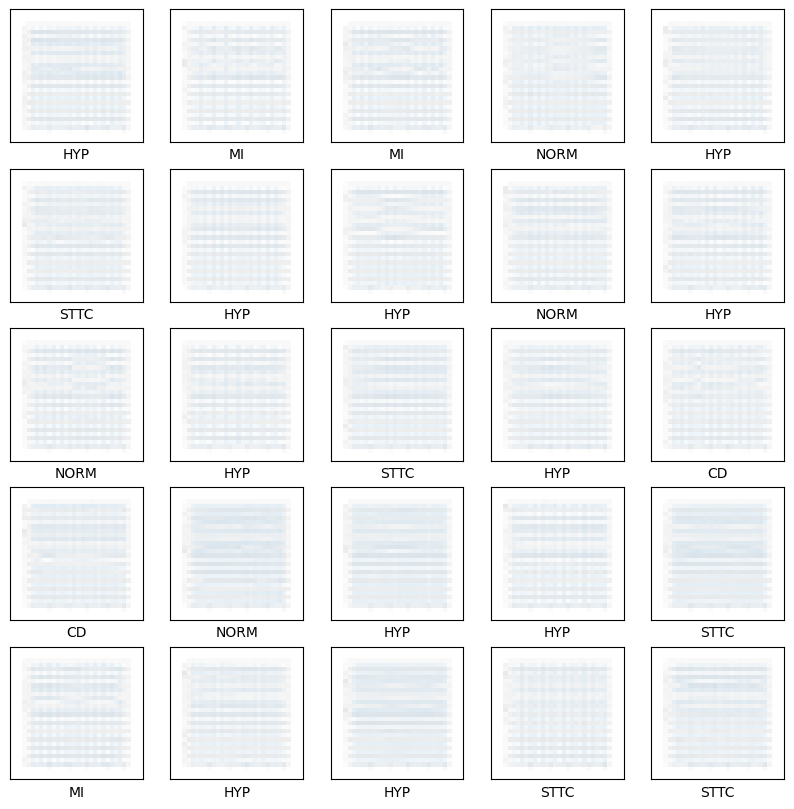

In [78]:
class_names = ['STTC','NORM','MI','HYP','CD']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img_array[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_ans_array[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [79]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [80]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 5632

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [81]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [82]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [84]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4278 - accuracy: 0.4833 - val_loss: 1.1979 - val_accuracy: 0.5758
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1626 - accuracy: 0.5883 - val_loss: 1.1150 - val_accuracy: 0.6035
Epoch 3/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.0311 - accuracy: 0.6378 - val_loss: 1.0313 - val_accuracy: 0.6366
Epoch 4/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.9402 - accuracy: 0.6705 - val_loss: 0.9413 - val_accuracy: 0.6736
Epoch 5/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.8579 - accuracy: 0.6983 - val_loss: 0.9081 - val_accuracy: 0.6894
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8044 - accuracy: 0.7184 - val_loss: 0.8739 - val_accuracy: 0.7021
Epoch 7/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.7531 - accuracy: 0.7348 - val_loss: 0.8917 - val_ac

### Evaluate the model

313/313 - 1s - loss: 0.8727 - accuracy: 0.7081 - 506ms/epoch - 2ms/step


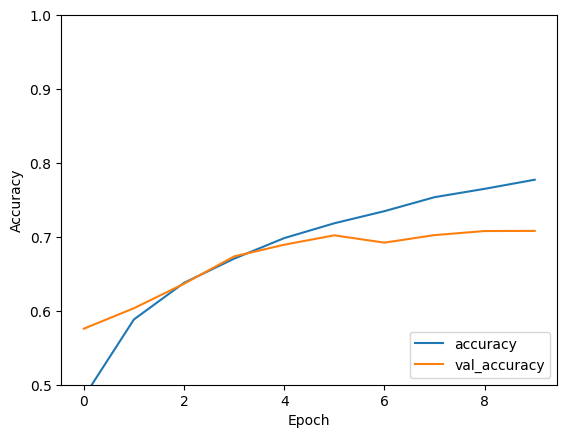

In [85]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [86]:
print(test_acc)

0.7081000208854675


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.